In [1]:
import pickle
import zstandard as zstd
import numpy as np
import uuid
import glob
import cv2
import matplotlib.pyplot as plt
import os
from dataclasses import dataclass, field
import dataclasses
import shortuuid
import zstandard as zstd
import pickle

from simnet.lib.datapoint import Stereo, Panoptic

#Step 0: Load images and masks
left_color_image_path = '/nfs/aiteam/arjun/Development/leap/CenterSnap/realsense_capture/realsense_images_translation/'
right_color_image_path = '/nfs/aiteam/arjun/Development/leap/CenterSnap/realsense_capture/realsense_images_translation/'
depth_image_path = '/nfs/aiteam/arjun/Development/leap/CenterSnap/realsense_capture/realsense_images_translation/'
segmentation_mask_path = '/nfs/aiteam/arjun/Development/leap/avocado/results/mask_images/'

## these will remain the same
# Initialize other required fields as per your data structure (empty or None as placeholders)
boxes = []  # or your actual boxes data if available
keypoints = []  # or your actual keypoints data if available
instance_mask = None  # or your actual instance mask if available
detections = []  # or your actual detections data if available
SCENE_NAME = "avocado_scene_test1"
OUTPUT_FILE_PATH = f"{SCENE_NAME}_dataset"
if not os.path.exists(OUTPUT_FILE_PATH):
    os.makedirs(OUTPUT_FILE_PATH)

segmentation_mask_files = glob.glob(segmentation_mask_path + "*.npy*")
for mask in segmentation_mask_files:
    mask_id = mask.split('binary_mask')[1].split('.')[0]
    print(f"processing mask_id: {mask_id}")

    # load png
    left_color_image = cv2.imread(left_color_image_path + f"color_image_{mask_id}.png")
    depth_image = cv2.imread(os.path.join(depth_image_path, f"depth_image_{mask_id}.png"), cv2.IMREAD_UNCHANGED)
    # Convert depth image to meters and to float32.
    depth_image = (depth_image / 1000.0).astype(np.float32)
    # right_color_image = cv2.applyColorMap(cv2.convertScaleAbs(depth_image, alpha=0.5), cv2.COLORMAP_JET)[:,:,2]
    right_color_image = depth_image
    segmentation_mask = np.load(segmentation_mask_path + f"binary_mask{mask_id}.png.png.npy").astype(np.float32)
    segmentation_mask[segmentation_mask == 10] = 1


    panoptic_instance = Panoptic(
        stereo=Stereo(left_color=left_color_image, right_color=right_color_image),
        depth=depth_image,
        segmentation=segmentation_mask,
        object_poses=[],
        boxes=[],
        detections=[],
        keypoints=[],
        instance_mask=None,
        scene_name=SCENE_NAME
)

    # Serialize the instance
    serialized_data = pickle.dumps(panoptic_instance)

    # Compress with zstandard
    compressor = zstd.ZstdCompressor()
    compressed_data = compressor.compress(serialized_data)

    # Save to a .pickle.zstd file
    output_file_path = f"{OUTPUT_FILE_PATH}/{panoptic_instance.uid}.pickle.zstd"
    with open(output_file_path, "wb") as output_file:
        output_file.write(compressed_data)

    print(f"Data saved to {output_file_path}")

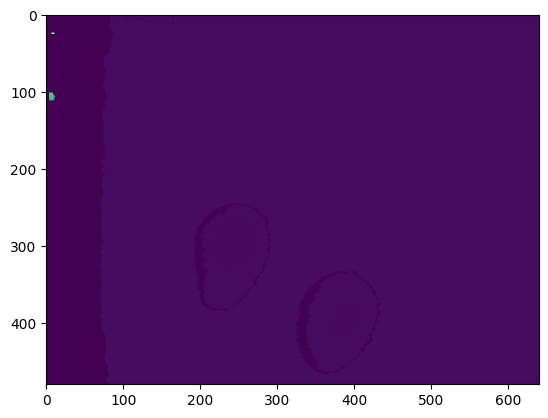

In [34]:
depth_image = cv2.imread(os.path.join(depth_image_path, f"depth_image_{mask_id}.png"), cv2.IMREAD_UNCHANGED)  # Load with depth


plt.imshow(depth_image)
plt.show()